In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [11]:
# Step 1: Load Data
bugs_df = pd.read_csv("cassandra/cassandra_bugs.csv")
duplicates_df = pd.read_csv("cassandra/cassandra_bugs-combined.csv")

In [12]:
# Step 2: Preprocessing
# Merge Summary and Description
bugs_df["text"] = bugs_df[["Summary", "Description"]].fillna("").agg(" ".join, axis=1)

# Map issue ID to text
issue_text_map = dict(zip(bugs_df["Issue id"], bugs_df["text"]))

# Clean duplicate ID column: handle comma-separated IDs
duplicates_df["Duplicate id"] = duplicates_df["Duplicate id"].astype(str).str.split(r",\s*")
duplicates_df = duplicates_df.explode("Duplicate id")

# Convert to integers and drop invalid rows
duplicates_df["Issue id"] = pd.to_numeric(duplicates_df["Issue id"], errors='coerce')
duplicates_df["Duplicate id"] = pd.to_numeric(duplicates_df["Duplicate id"], errors='coerce')
duplicates_df = duplicates_df.dropna().astype(int)

# Filter for valid IDs present in text map
duplicates_df = duplicates_df[
    (duplicates_df["Issue id"].isin(issue_text_map)) &
    (duplicates_df["Duplicate id"].isin(issue_text_map))
]

In [13]:
# Step 3: TF-IDF Vectorization
all_ids = list(issue_text_map.keys())
all_texts = [issue_text_map[iid] for iid in all_ids]

vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Index mapping
id_to_index = {iid: idx for idx, iid in enumerate(all_ids)}

In [14]:
# Step 4: IR-based Retrieval
results = []

for _, row in duplicates_df.iterrows():
    qid = row["Issue id"]
    true_duplicate = row["Duplicate id"]

    if qid not in id_to_index or true_duplicate not in id_to_index:
        continue

    q_idx = id_to_index[qid]
    q_vec = tfidf_matrix[q_idx]

    similarities = cosine_similarity(q_vec, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[::-1][1:11]  # Exclude self
    top_ids = [all_ids[i] for i in top_indices]
    top_scores = similarities[top_indices]

    found = true_duplicate in top_ids

    results.append({
        "query_id": qid,
        "true_duplicate": true_duplicate,
        "found_in_top_10": found,
        "top_10_ranked_ids": top_ids,
        "top_10_scores": top_scores.tolist()
    })


Recall@10: 0.61 over 300 queries


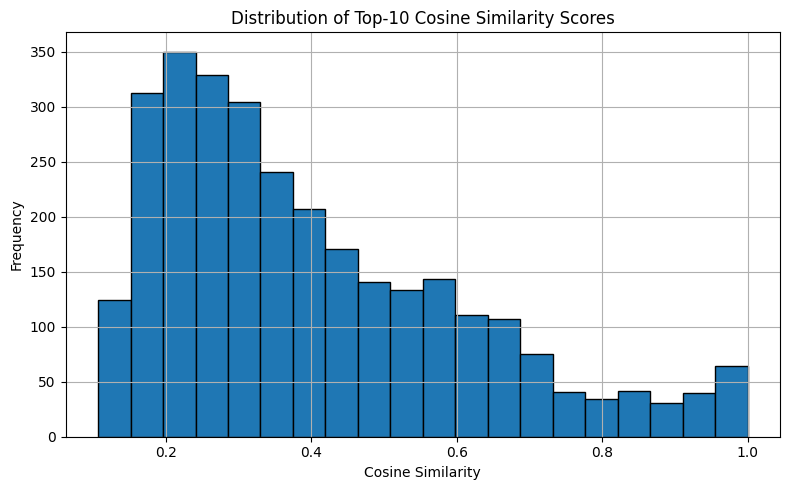

In [15]:
# Step 5: Evaluate Recall@10
recall_at_10 = sum(r["found_in_top_10"] for r in results) / len(results)
print(f"Recall@10: {recall_at_10:.2f} over {len(results)} queries")

# Step 6: Score Distribution Plot
all_scores = [score for r in results for score in r["top_10_scores"]]

plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=20, edgecolor='black')
plt.title("Distribution of Top-10 Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
